In [1]:
import os
import shutil
import json
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set(font_scale=1.2)
import tensorflow as tf

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/yonzhang/opt/anaconda3/envs

In [19]:
cp = shutil.copyfile
cp_r = shutil.copytree
join = os.path.join
mv = shutil.move

PARAMS_FILE = "params.json"
EVAL_KEY = "Eval_AverageReturn"
EVAL_STD_KEY = "Eval_StdReturn"
TRAIN_KEY = "Train_AverageReturn"
TRAIN_STD_KEY = "Train_StdReturn"
KEYS= [EVAL_KEY, EVAL_STD_KEY, TRAIN_KEY, TRAIN_STD_KEY]


def load_json(filename):
    with open(filename, "r+") as f:
        ret = json.load(f)
        f.close()
        return ret

def dump_json(data, filename):
    with open(filename, "w") as f:
        json.dump(data, f)
        f.close()

def smooth_data(l, width):
    length = len(l)
    target = np.array([np.mean(l[max(0, i - width): min(i + width + 1, length)]) for i in range(length)])

    return target

def plot_df(datas, title, labels, line_styles, x_label='Epochs', y_label='Average Returns', colors=None):
    fig, (axis) = plt.subplots(1, 1, figsize=(20/3.,5))
    axis.set_title(title)
    if colors is None:
        colors = [None for _ in datas]
    if type(line_styles) != list:
        line_styles = [line_styles for _ in datas]
    for d, l, c, l_style in zip(datas, labels, colors, line_styles):
        df = pd.DataFrame(d)
        df = df.rename(columns={0: x_label, 1:y_label})
        plot_single_df(df, l, c, l_style, axis, x_label, y_label)
    plt.show()

def plot_single_df(data, label, color, line_style, axis, x_label, y_label):
    if color is None:
        sns.lineplot(data=data, x=x_label, y=y_label, ax=axis, label=label)
    else:
        sns.lineplot(data=data, x=x_label, y=y_label, ax=axis, label=label, c=color)
    axis.lines[-1].set_linestyle(line_style)

        
def is_summary_file(filename):
    return filename.startswith("events.")


def summary_to_dict_list(file, keys=[EVAL_KEY]):
    dict_list = {}
    for k in keys:
        dict_list[k] = []
    for e in tf.train.summary_iterator(file):
        for v in e.summary.value:
            key, value = v.tag, v.simple_value
            if (keys == 'all') or (key in keys):
                dict_list[key].append(value)
    return dict_list

def smooth_data(l, width):
    length = len(l)
    target = np.array([np.mean(l[max(0, i - width): min(i + width + 1, length)]) for i in range(length)])
    return target

def params_match(big, small):
    for k in small:
        if big[k] != small[k]:
            return False
    return True

def iterate_summary_and_config(directory):
    for root, dirs, files in os.walk(directory):
        if PARAMS_FILE in files:
            config = load_json(join(root, PARAMS_FILE))
            for f in files: 
                if is_summary_file(f):
                    yield join(root, f), config

def get_array_df(data):
    ret = []
    for i, d in enumerate(data):
        ret.append((i, d))
    return ret

def get_df(directory, condition, key=EVAL_KEY, width=0):
    ret = []
    for root, dirs, files in os.walk(directory):
        if PARAMS_FILE in files:
            config = load_json(join(root, PARAMS_FILE))
            if params_match(big=config, small=condition):
                for f in files:
                    if is_summary_file(f):
                        dict_list = summary_to_dict_list(join(root, f), keys=[key])
                        data = dict_list[key]
                        data = smooth_data(data, width)
                        for i, d in enumerate(data):
                            ret.append((i, d))
    return ret

def create_name(keys, values):
    return ", ".join(["{}={}".format(str(k), str(v)) for k, v in zip(keys, values)])

def dict_to_kv_lists(d):
    k_l, v_l = [], []
    for k in sorted(d.keys()):
        v = d[k]
        k_l.append(k)
        v_l.append(v)
    return k_l, v_l

def split_plot(directory, plot_key=EVAL_KEY, split_line_keys=None, split_graph_keys=None, colors=None):
    ret = {}
    split_line_keys.sort()
    split_graph_keys.sort()
    for sum_file, config in iterate_summary_and_config(directory):
        data = summary_to_dict_list(sum_file, keys=[plot_key])[plot_key]
        df_list = get_array_df(data)
        
        graph_key, line_key = [], []
        for k in split_graph_keys:
            graph_key.append(config[k])
        for k in split_line_keys:
            line_key.append(config[k])
        graph_key, line_key = tuple(graph_key), tuple(line_key)
        
        if graph_key not in ret:
            ret[graph_key] = {}
        if line_key not in ret[graph_key]:
            ret[graph_key][line_key] = []
        ret[graph_key][line_key] += df_list
        
    for graph_key in sorted(ret.keys()):
        d = ret[graph_key]
        title_name = create_name(split_graph_keys, graph_key)
        line_keys, line_values = dict_to_kv_lists(d)
        labels = [create_name(split_line_keys, k) for k in line_keys]
        if colors is not None:
            assert type(colors) == list
            assert len(line_values) == len(colors), "Number of unique lines and number of colors don't match"
            plot_df(datas=line_values, labels=labels, title=title_name, line_styles='-', colors=colors)
        else:
            plot_df(datas=line_values, labels=labels, title=title_name, line_styles='-')
        
        
        
    
    

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


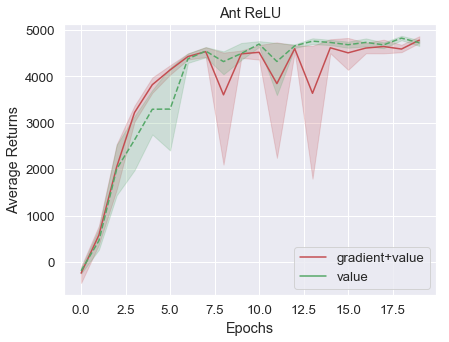

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


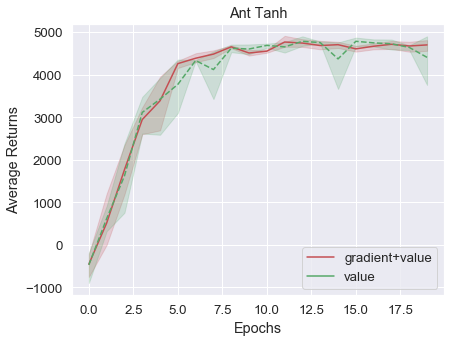

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


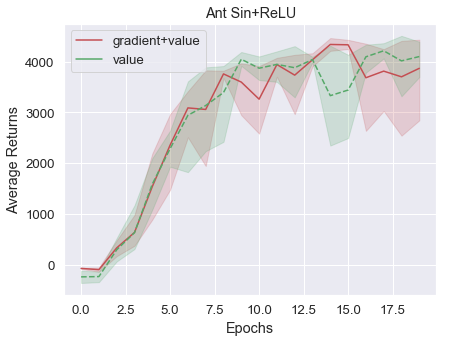

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


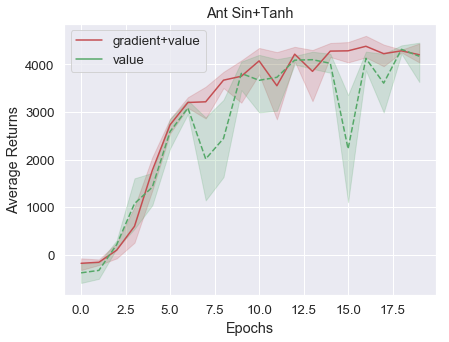

In [20]:
df1 = get_df("../paf-data/tune_ant/", 
       {"learning_rate":0.0008, 
        "siren": False, 
        "supervision_mode": "gv", 
        "train_separate_offset": True, 
        "additional_activation": "relu"},
      )

df2 = get_df("../paf-data/tune_ant/", 
       {"learning_rate":0.0008, 
        "siren": False, 
        "supervision_mode": "value", 
        "train_separate_offset": True, 
        "additional_activation": "relu"},
      )

plot_df([df1, df2], "Ant ReLU", ["gradient+value", 'value'], ['-','--'], colors=['r','g'])

df1 = get_df("../paf-data/tune_ant/", 
       {"learning_rate":0.0008, 
        "siren": False, 
        "supervision_mode": "gv", 
        "train_separate_offset": True, 
        "additional_activation": "tanh"},
      )

df2 = get_df("../paf-data/tune_ant/", 
       {"learning_rate":0.0008, 
        "siren": False, 
        "supervision_mode": "value", 
        "train_separate_offset": True, 
        "additional_activation": "tanh"},
      )

plot_df([df1, df2], "Ant Tanh", ["gradient+value", 'value'], ['-','--'], colors=['r','g'])

df1 = get_df("../paf-data/tune_ant/", 
       {"learning_rate":0.0005, 
        "siren": True, 
        "supervision_mode": "gv", 
        "train_separate_offset": True, 
        "additional_activation": "relu"},
      )

df2 = get_df("../paf-data/tune_ant/", 
       {"learning_rate":0.0005, 
        "siren": True, 
        "supervision_mode": "value", 
        "train_separate_offset": True, 
        "additional_activation": "relu"},
      )

plot_df([df1, df2], "Ant Sin+ReLU", ["gradient+value", 'value'], ['-','--'], colors=['r','g'])

df1 = get_df("../paf-data/tune_ant/", 
       {"learning_rate":0.0005, 
        "siren": True, 
        "supervision_mode": "gv", 
        "train_separate_offset": True, 
        "additional_activation": "tanh"},
      )

df2 = get_df("../paf-data/tune_ant/", 
       {"learning_rate":0.0005, 
        "siren": True, 
        "supervision_mode": "value", 
        "train_separate_offset": True, 
        "additional_activation": "tanh"},
      )

plot_df([df1, df2], "Ant Sin+Tanh", ["gradient+value", 'value'], ['-','--'], colors=['r','g'])

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


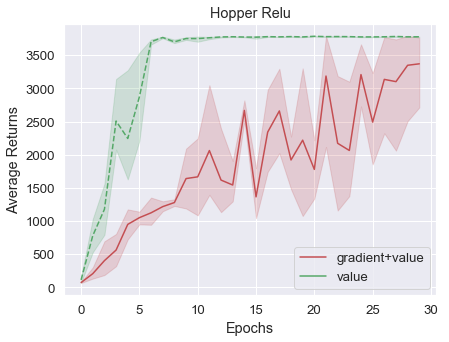

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


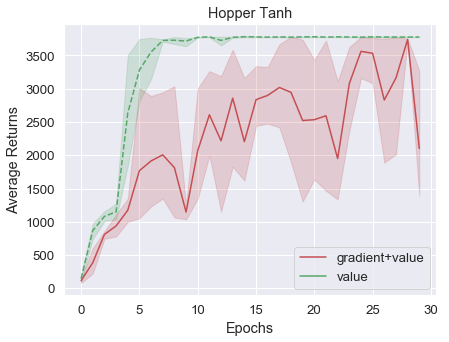

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


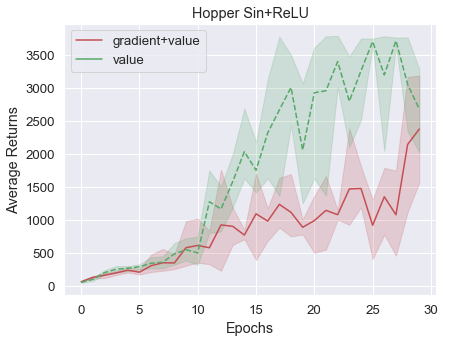

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


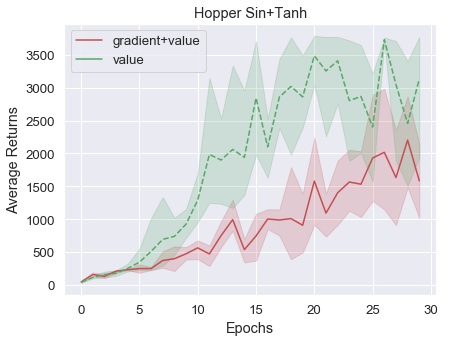

In [14]:
df1 = get_df("../paf-data/09-05-2021_11-52-20-tune_hopper/", 
       {"learning_rate":0.0002, 
        "siren": False, 
        "supervision_mode": "gv", 
        "train_separate_offset": True, 
        "additional_activation": "relu"},
      )

df2 = get_df("../paf-data/09-05-2021_11-52-20-tune_hopper/", 
       {"learning_rate":0.0008, 
        "siren": False, 
        "supervision_mode": "value", 
        "train_separate_offset": True, 
        "additional_activation": "relu"},
      )

plot_df([df1, df2], "Hopper Relu", ["gradient+value", 'value'], ['-','--'], colors=['r','g'])

df1 = get_df("../paf-data/09-05-2021_11-52-20-tune_hopper/", 
       {"learning_rate":0.0005, 
        "siren": False, 
        "supervision_mode": "gv", 
        "train_separate_offset": True, 
        "additional_activation": "tanh"},
      )

df2 = get_df("../paf-data/09-05-2021_11-52-20-tune_hopper/", 
       {"learning_rate":0.0008, 
        "siren": False, 
        "supervision_mode": "value", 
        "train_separate_offset": True, 
        "additional_activation": "tanh"},
      )

plot_df([df1, df2], "Hopper Tanh", ["gradient+value", 'value'], ['-','--'], colors=['r','g'])

df1 = get_df("../paf-data/09-05-2021_11-52-20-tune_hopper/", 
       {"learning_rate":0.0005, 
        "siren": True, 
        "supervision_mode": "gv", 
        "train_separate_offset": True, 
        "additional_activation": "relu"},
      )

df2 = get_df("../paf-data/09-05-2021_11-52-20-tune_hopper/", 
       {"learning_rate":0.0005, 
        "siren": True, 
        "supervision_mode": "value", 
        "train_separate_offset": True, 
        "additional_activation": "relu"},
      )

plot_df([df1, df2], "Hopper Sin+ReLU", ["gradient+value", 'value'], ['-','--'], colors=['r','g'])

df1 = get_df("../paf-data/09-05-2021_11-52-20-tune_hopper/", 
       {"learning_rate":0.0005, 
        "siren": True, 
        "supervision_mode": "gv", 
        "train_separate_offset": True, 
        "additional_activation": "tanh"},
      )

df2 = get_df("../paf-data/09-05-2021_11-52-20-tune_hopper/", 
       {"learning_rate":0.0005, 
        "siren": True, 
        "supervision_mode": "value", 
        "train_separate_offset": True, 
        "additional_activation": "tanh"},
      )

plot_df([df1, df2], "Hopper Sin+Tanh", ["gradient+value", 'value'], ['-','--'], colors=['r','g'])

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


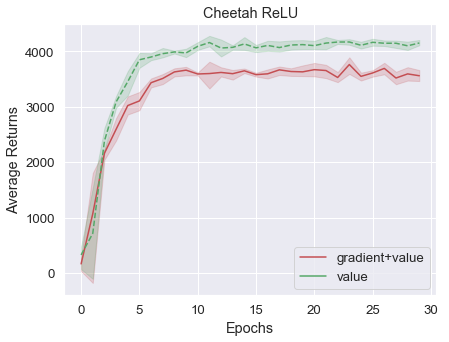

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


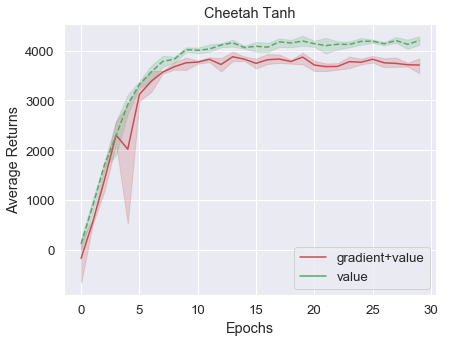

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


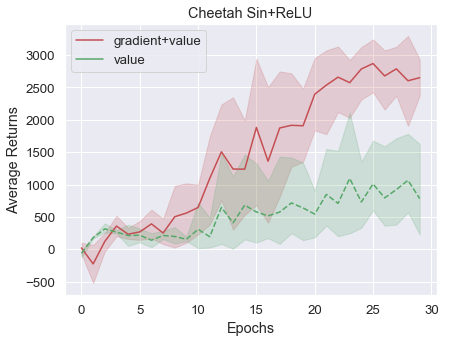

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


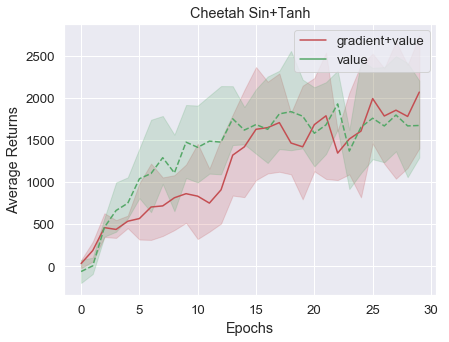

In [15]:
df1 = get_df("../paf-data/tune_cheetah/", 
       {"learning_rate":0.0008, 
        "siren": False, 
        "supervision_mode": "gv", 
        "train_separate_offset": True, 
        "additional_activation": "relu"},
      )

df2 = get_df("../paf-data/tune_cheetah/", 
       {"learning_rate":0.0008, 
        "siren": False, 
        "supervision_mode": "value", 
        "train_separate_offset": True, 
        "additional_activation": "relu"},
      )

plot_df([df1, df2], "Cheetah ReLU", ["gradient+value", 'value'], ['-','--'], colors=['r','g'])

df1 = get_df("../paf-data/tune_cheetah/", 
       {"learning_rate":0.0005, 
        "siren": False, 
        "supervision_mode": "gv", 
        "train_separate_offset": True, 
        "additional_activation": "tanh"},
      )

df2 = get_df("../paf-data/tune_cheetah/", 
       {"learning_rate":0.0005, 
        "siren": False, 
        "supervision_mode": "value", 
        "train_separate_offset": True, 
        "additional_activation": "tanh"},
      )

plot_df([df1, df2], "Cheetah Tanh", ["gradient+value", 'value'], ['-','--'], colors=['r','g'])

df1 = get_df("../paf-data/tune_cheetah/", 
       {"learning_rate":0.0005, 
        "siren": True, 
        "supervision_mode": "gv", 
        "train_separate_offset": True, 
        "additional_activation": "relu"},
      )

df2 = get_df("../paf-data/tune_cheetah/", 
       {"learning_rate":0.0005, 
        "siren": True, 
        "supervision_mode": "value", 
        "train_separate_offset": True, 
        "additional_activation": "relu"},
      )

plot_df([df1, df2], "Cheetah Sin+ReLU", ["gradient+value", 'value'], ['-','--'], colors=['r','g'])

df1 = get_df("../paf-data/tune_cheetah/", 
       {"learning_rate":0.0005, 
        "siren": True, 
        "supervision_mode": "gv", 
        "train_separate_offset": True, 
        "additional_activation": "tanh"},
      )

df2 = get_df("../paf-data/tune_cheetah/", 
       {"learning_rate":0.0005, 
        "siren": True, 
        "supervision_mode": "value", 
        "train_separate_offset": True, 
        "additional_activation": "tanh"},
      )

plot_df([df1, df2], "Cheetah Sin+Tanh", ["gradient+value", 'value'], ['-','--'], colors=['r','g'])

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


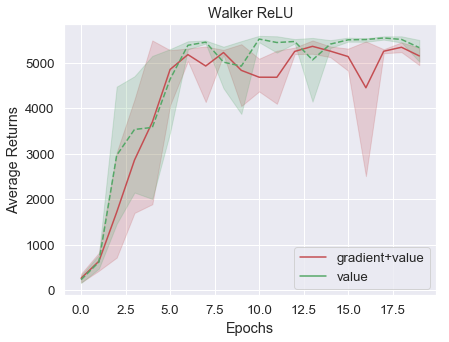

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


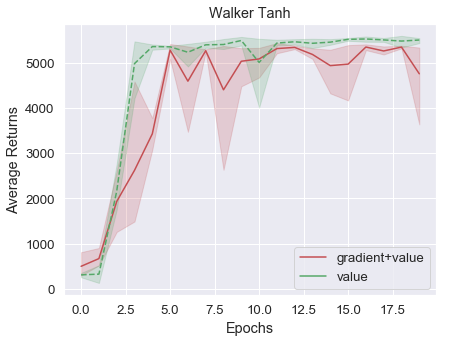

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


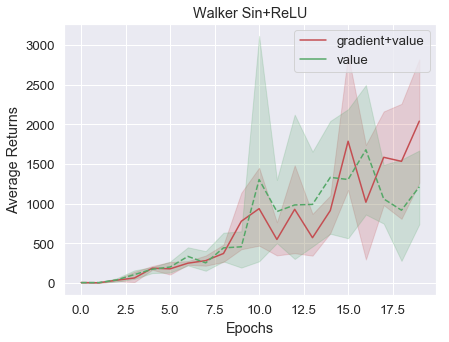

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


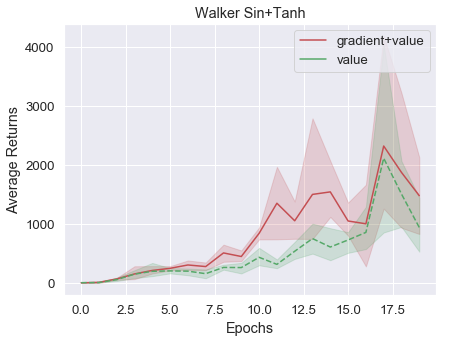

In [16]:
df1 = get_df("../paf-data/09-05-2021_16-40-31-tune_walker/", 
       {"learning_rate":0.0008, 
        "siren": False, 
        "supervision_mode": "gv", 
        "train_separate_offset": True, 
        "additional_activation": "relu"},
      )

df2 = get_df("../paf-data/09-05-2021_16-40-31-tune_walker/", 
       {"learning_rate":0.0008, 
        "siren": False, 
        "supervision_mode": "value", 
        "train_separate_offset": True, 
        "additional_activation": "relu"},
      )

plot_df([df1, df2], "Walker ReLU", ["gradient+value", 'value'], ['-','--'], colors=['r','g'])

df1 = get_df("../paf-data/09-05-2021_16-40-31-tune_walker/", 
       {"learning_rate":0.0008, 
        "siren": False, 
        "supervision_mode": "gv", 
        "train_separate_offset": True, 
        "additional_activation": "tanh"},
      )

df2 = get_df("../paf-data/09-05-2021_16-40-31-tune_walker/", 
       {"learning_rate":0.0008, 
        "siren": False, 
        "supervision_mode": "value", 
        "train_separate_offset": True, 
        "additional_activation": "tanh"},
      )

plot_df([df1, df2], "Walker Tanh", ["gradient+value", 'value'], ['-','--'], colors=['r','g'])

df1 = get_df("../paf-data/09-05-2021_16-40-31-tune_walker/", 
       {"learning_rate":0.0005, 
        "siren": True, 
        "supervision_mode": "gv", 
        "train_separate_offset": True, 
        "additional_activation": "relu"},
      )

df2 = get_df("../paf-data/09-05-2021_16-40-31-tune_walker/", 
       {"learning_rate":0.0005, 
        "siren": True, 
        "supervision_mode": "value", 
        "train_separate_offset": True, 
        "additional_activation": "relu"},
      )

plot_df([df1, df2], "Walker Sin+ReLU", ["gradient+value", 'value'], ['-','--'], colors=['r','g'])

df1 = get_df("../paf-data/09-05-2021_16-40-31-tune_walker/", 
       {"learning_rate":0.0005, 
        "siren": True, 
        "supervision_mode": "gv", 
        "train_separate_offset": True, 
        "additional_activation": "tanh"},
      )

df2 = get_df("../paf-data/09-05-2021_16-40-31-tune_walker/", 
       {"learning_rate":0.0005, 
        "siren": True, 
        "supervision_mode": "value", 
        "train_separate_offset": True, 
        "additional_activation": "tanh"},
      )

plot_df([df1, df2], "Walker Sin+Tanh", ["gradient+value", 'value'], ['-','--'], colors=['r','g'])

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


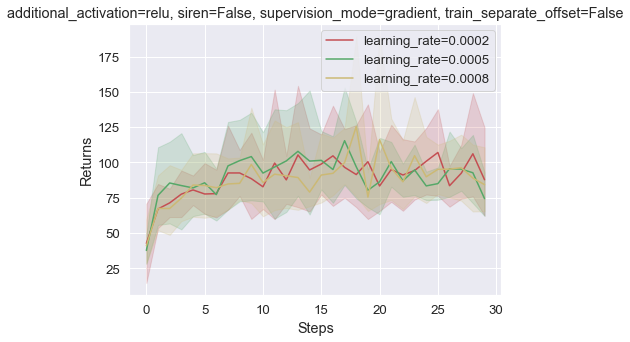

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


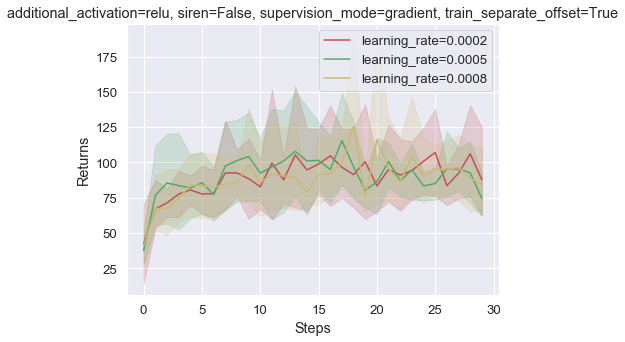

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


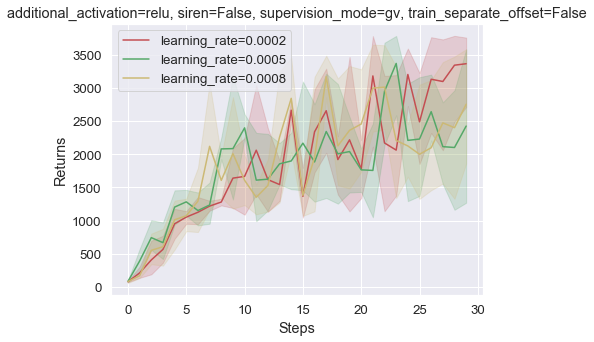

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


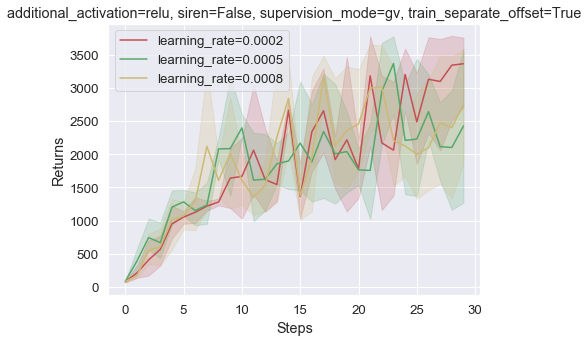

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


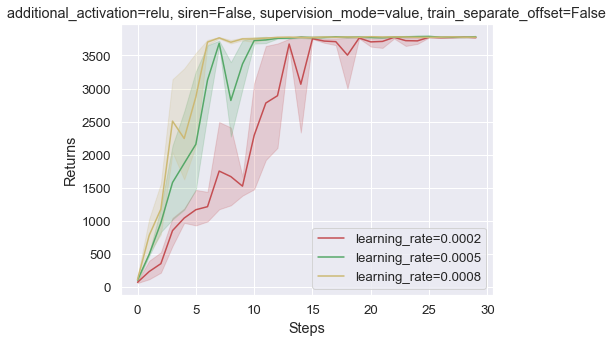

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


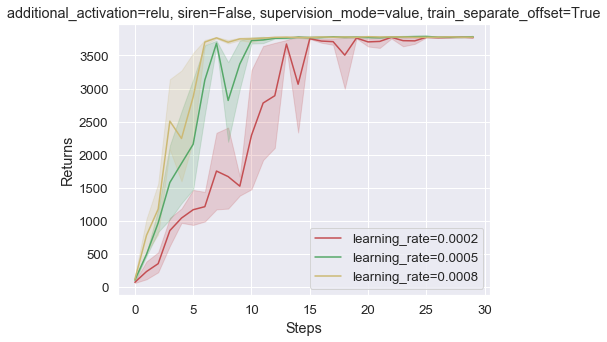

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


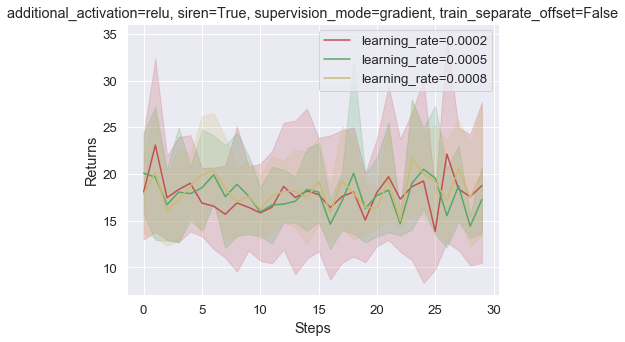

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


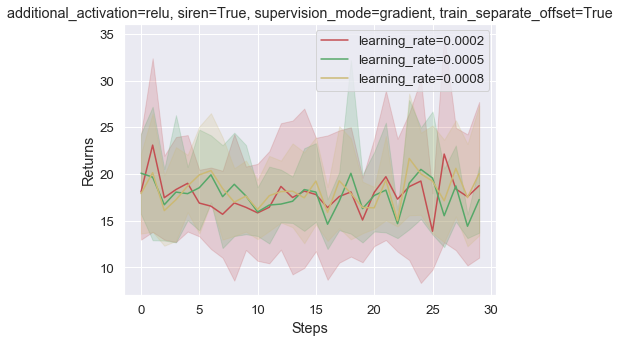

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


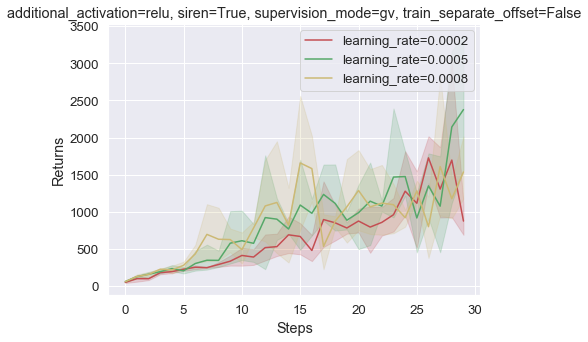

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


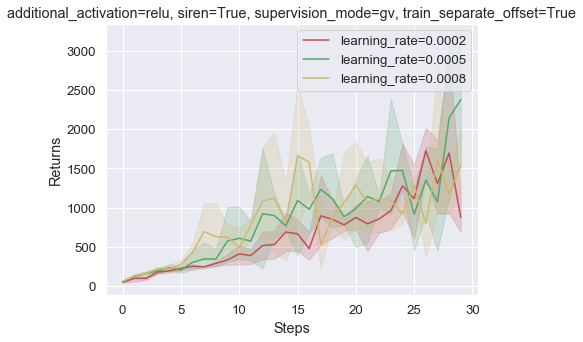

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


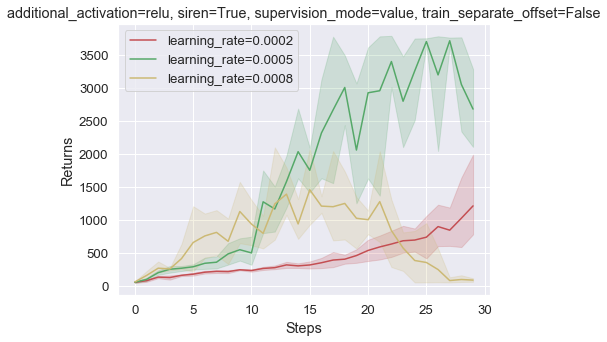

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


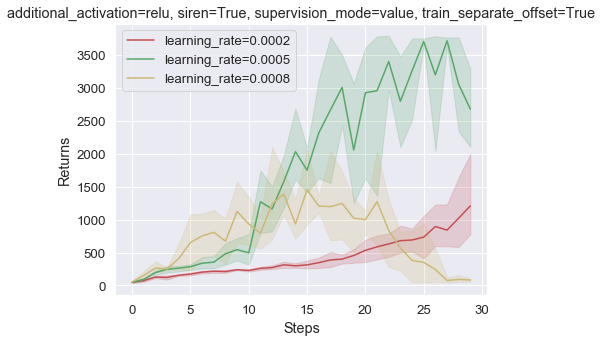

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


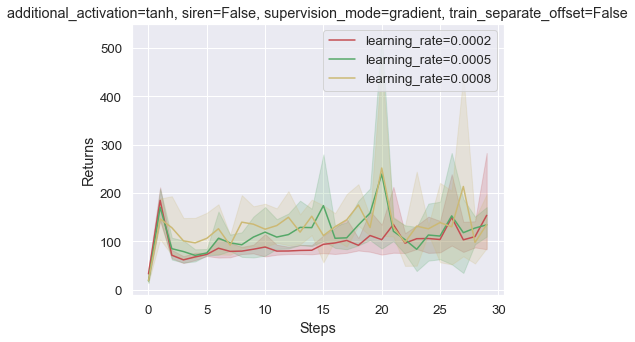

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


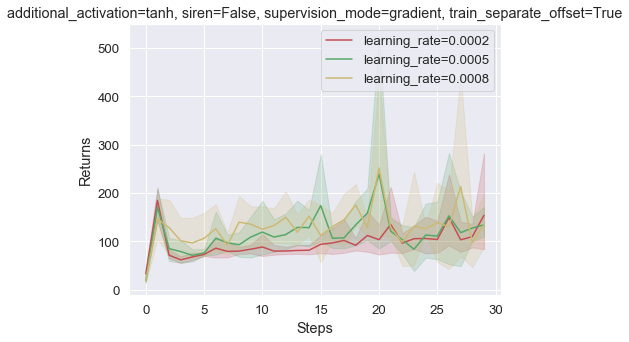

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


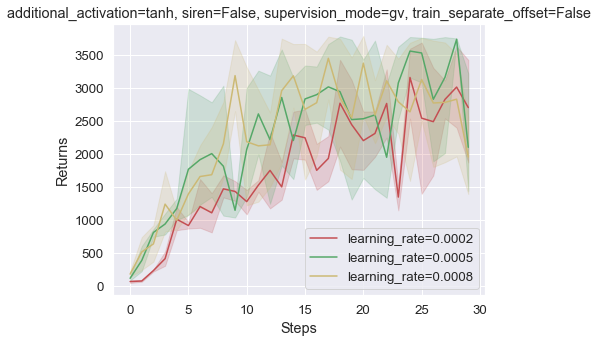

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


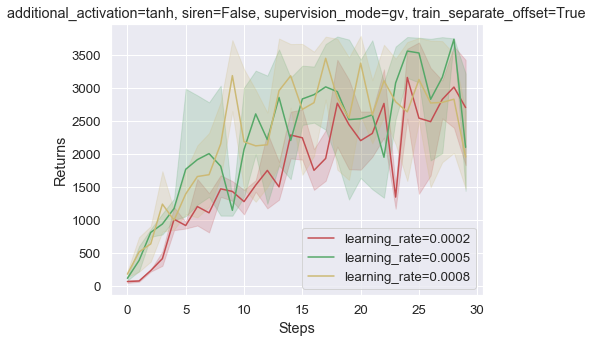

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


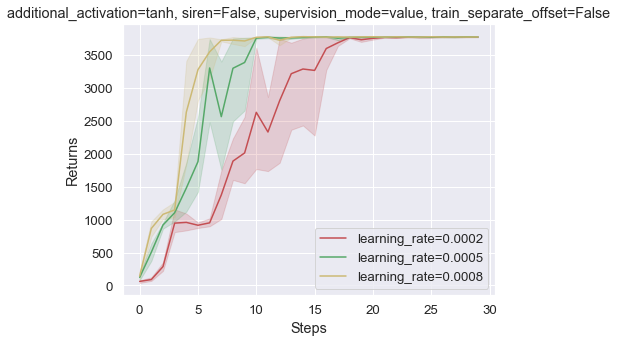

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


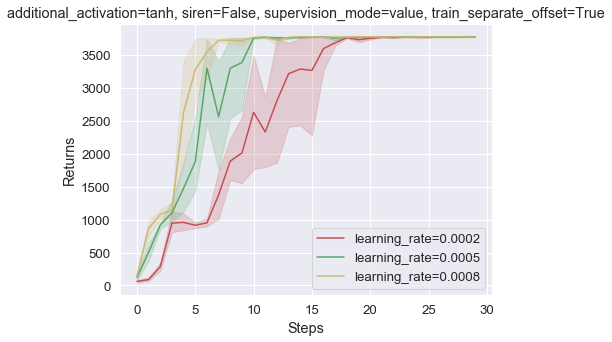

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


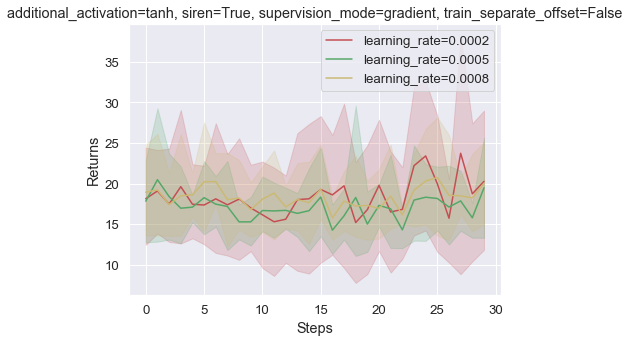

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


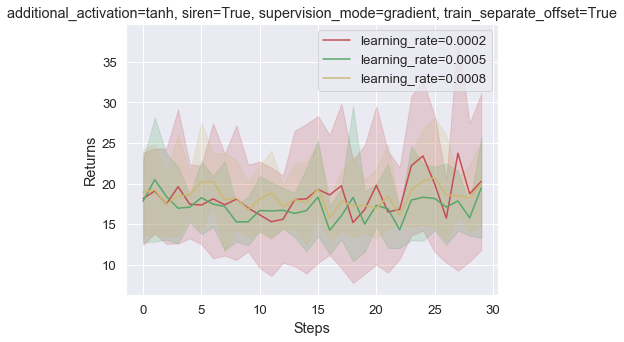

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


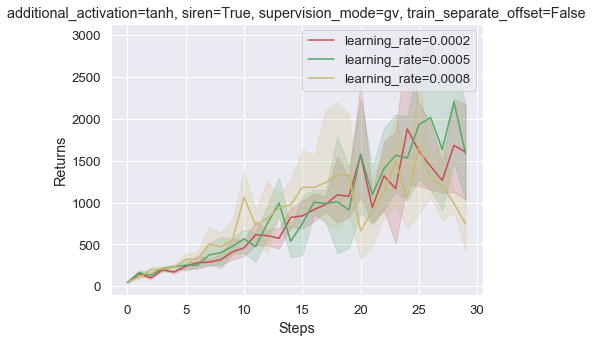

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


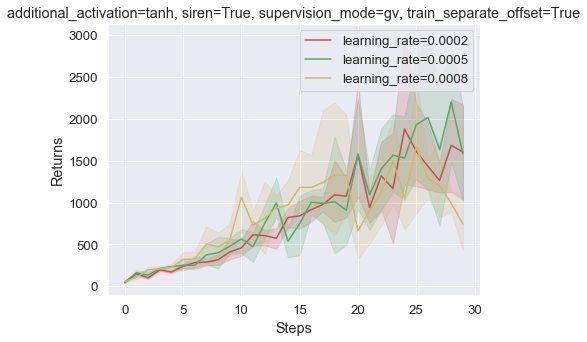

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


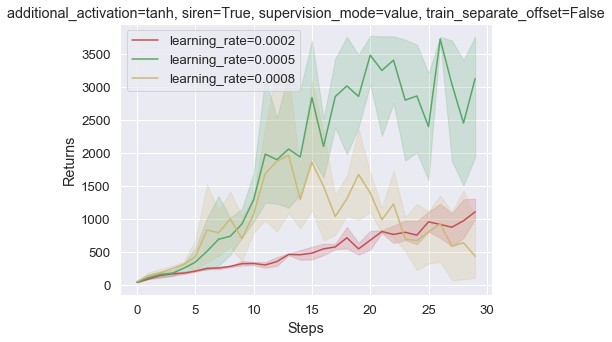

/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yonzhang/opt/anaconda3/envs/paf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


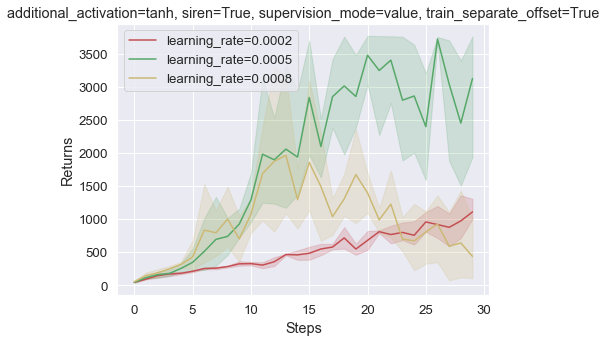

In [6]:
# split_plot(directory="../paf-data/09-05-2021_11-52-20-tune_hopper/", 
#            split_graph_keys=['siren', 'train_separate_offset', 'additional_activation', "supervision_mode"], 
#            split_line_keys=["learning_rate"], 
#            colors=['r', 'g', 'y'])